In [44]:
from Advertising.learners.greedyLearner import *
import matplotlib.pyplot as plt
import numpy as np
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.GTS_Learner import *
from Advertising.learners.GTS_SW_Learner import *
from Advertising.learners.TS_no_qualities import *
from tqdm.autonotebook import tqdm
import itertools
seed = 6789
random.seed(seed)
only_first = False


lambdas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')

adversary_bids = []
for _ in range(0, 10):
    adversary_i_bids = []
    for __ in range(0, 5):
        adversary_i_bids.append(random.randint(0, 4))
    adversary_bids.append(adversary_i_bids)


with open("Config/estimated_influence.json", "r"):
    data = json.load(open("Config/estimated_influence.json"))

active_by_influence_reward = np.array(data.get("estimated_influence"))


In [45]:
def test_sw(learner, arms, adversary_bids, only_first, active_by_influence_reward, n_rounds, lambdas, social_network, sw_size):
    clairvoyants = []
    clair_ex = []
    vcg = VCG(lambdas)
    number_of_pulls = [0]*len(arms)
    sum_expected_values = [0]*len(arms)
    expected_values = [0]*len(arms)
    thing_to_plot = []
    thing_to_plot.append(0)
    t = 0
    for i in range(0, n_rounds):
        t += 1
        arm_learner, pulled_arm = learner.pull_arm()

        if t > sw_size:
            adversary_bids = []
            for _ in range(0, 10):
                adversary_i_bids = []
                for __ in range(0, 5):
                    adversary_i_bids.append(random.randint(0, 4))
                adversary_bids.append(adversary_i_bids)
            clairvoyants.append(np.argmax(expected_values))
            clair_ex.append(expected_values[np.argmax(expected_values)])
            t = 0

        all_bids = []
        all_bids.append(arm_learner)
        for element in adversary_bids:
            all_bids.append(element)
        ad_allocation_list = setup(bids=all_bids, n_bids=5)

        best_allocation = vcg.all_best_allocations(
            list_camp_bids=ad_allocation_list, social_network=social_network)

        if only_first:
            for j in range(0, len(best_allocation)):
                temp_allocation = []
                temp_allocation = best_allocation[j]
                for k in range(0, len(best_allocation[j])):
                    if temp_allocation[k].ad_id == 1 and k != 0:
                        temp_allocation[k].ad_id = None
                        best_allocation[j] = temp_allocation

        total_reward, active_nodes = activate_cascade(
            social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas)

        payments = vcg.payments(
            ad_allocation_list, best_allocation, social_network=social_network)
    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.

        payments_tot = calculate_total_payment(
            payments, social_network.categories, active_nodes)

        reward = total_reward - payments_tot

        if i > 0:
            thing_to_plot.append((reward+thing_to_plot[-1]*(i-1))/i)

        #rew = reward-np.sum(payments_tot)

        number_of_pulls[pulled_arm] += 1
        sum_expected_values[pulled_arm] += reward
        expected_values[pulled_arm] = sum_expected_values[pulled_arm] / \
            number_of_pulls[pulled_arm]

    # updating of the learners
        learner.update(pulled_arm, reward, number_of_pulls)
        reset_nodes(social_network=social_network)

    best_arm_index = np.argmax(expected_values)
    clairvoyants.append(np.argmax(expected_values))
    clair_ex.append(expected_values[np.argmax(expected_values)])

    print(expected_values)
    print(best_arm_index)

    return arms[best_arm_index], best_arm_index, number_of_pulls, expected_values, thing_to_plot, clairvoyants, clair_ex


In [46]:
expected_values = []
expected_values2 = []
sw_size = 4000
arms = arms_creation(seed=30291, number_of_arms=20)
ts_learner = GTS_SW_Learner(20, arms, variance=40, size_SW=sw_size, ad_id=1)
ts_learner2 = GTS_SW_Learner(20, arms, variance=40, size_SW=sw_size, ad_id=1)
n_experiments=10000

for j in range(0, 1):
    best_Arm = []
    print("This is TS number " + str(j))

    best_arm, best_arm_index, number_of_pulls, expected_values, thing_to_plot, clairvoyants, clair_ex = test_sw(
        ts_learner, arms, adversary_bids, only_first, active_by_influence_reward, n_experiments, lambdas, social_network, sw_size)
    best_arm2, best_arm_index2, number_of_pulls2, expected_values2, thing_to_plot2, clairvoyants2, clair_ex2 = test_sw(
        ts_learner2, arms, adversary_bids, not only_first, active_by_influence_reward, n_experiments, lambdas, social_network, sw_size)

    print("Valori non solo prima posizione:")
    print(best_arm)
    print(number_of_pulls)
    print(expected_values)

    print("Valori solo prima posizione:")
    print(best_arm2)
    print(number_of_pulls2)
    print(expected_values2)


This is TS number 0
[0.1363742690058453, 0.2079995443153343, 0.04049999999999791, -1.0633333333333326, 0.08785714285714279, -1.6325730994152048, -0.022459016393445407, 1.01137727496311, -2.1205291005291036, -2.7116842105263173, 0.7753410504678963, 0.9627234753550521, -1.1240000000000017, -3.5674999999999986, 2.0034767186165006, -1.9495488721804528, -0.7457499999999977, 0.6180402010050267, 1.5726340606303202, -0.7106265664160415]
14
[-3.365000000000003, 2.435000000000003, -1.3959999999999975, -0.521666666666665, 0.6011897926634806, 0.9749999999999992, -2.235000000000002, 1.1920000000000013, -0.2540000000000031, -0.7050000000000041, 1.9800000000000009, 1.760000000000001, -2.4775000000000027, -7.506666666666665, 0.0, -3.7266666666666697, 0.1925000000000031, 1.5261896986789394, 0.0, 1.5851851851851853]
1
Valori non solo prima posizione:
[2 3 2 1 1]
[18, 132, 40, 5, 6, 9, 61, 428, 27, 5, 278, 63, 5, 4, 6525, 7, 40, 199, 2141, 7]
[0.1363742690058453, 0.2079995443153343, 0.04049999999999791, 

THE BEST ARM FOR EXPERIMENT TOTAL IS: [2 3 2 1 1] INDEX 14
THE BEST ARM FOR EXPERIMENT ONLY FIRST IS: [3 3 4 2 3] INDEX 1


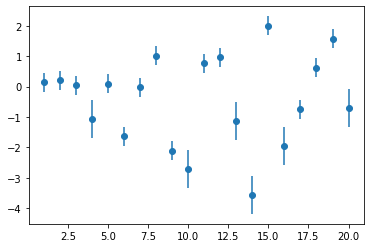

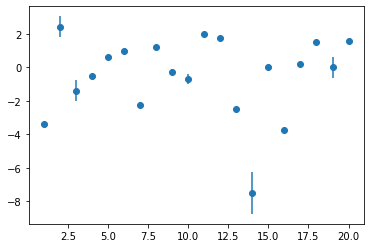

In [47]:
print("THE BEST ARM FOR EXPERIMENT TOTAL IS:",
      arms[best_arm_index], "INDEX", best_arm_index)
print("THE BEST ARM FOR EXPERIMENT ONLY FIRST IS:",
      arms[best_arm_index2], "INDEX", best_arm_index2)

array = [i+1 for i in range(0, 20)]


plt.figure(1)
plt.errorbar(array, expected_values, yerr=(1/ts_learner.tau0), fmt='o')
plt.figure(0)
plt.errorbar(array, expected_values2, yerr=(1/ts_learner2.tau0), fmt='o')

plt.show()


In [48]:
#Second test
n
ts_learner = GTS_SW_Learner(20, arms, variance=40, size_SW=sw_size, ad_id=1)
ts_learner2 = GTS_SW_Learner(20, arms, variance=40, size_SW=sw_size, ad_id=1)

for j in range(0, 1):
    best_Arm = []
    print("This is TS number " + str(j))

    best_arm, best_arm_index, number_of_pulls, expected_values, thing_to_plot, clairvoyants, clair_ex = test_sw(
        ts_learner, arms, adversary_bids, only_first, active_by_influence_reward, n_experiments, lambdas, social_network, sw_size)
    best_arm2, best_arm_index2, number_of_pulls2, expected_values2, thing_to_plot2, clairvoyants2, clair_ex2 = test_sw(
        ts_learner2, arms, adversary_bids, not only_first, active_by_influence_reward, n_experiments, lambdas, social_network, sw_size)

    print("Valori non solo prima posizione:")
    print(best_arm)
    print(number_of_pulls)
    print(expected_values[best_arm_index])

    print("Valori solo prima posizione:")
    print(best_arm2)
    print(number_of_pulls2)
    print(expected_values2[best_arm_index2])


This is TS number 0
[-0.590211670480549, -1.8807171775592846, -4.444000000000005, -0.707542188805347, 1.380647805955565, -2.6282236842105258, 0.2133953488372085, 0.4005436430582636, -2.6728571428571453, 0.39188201687013297, 1.0596396612336216, 0.6177441786283908, -0.18100000000000174, -4.28375, 1.7238086470087823, 0.1078144513826929, -2.0671428571428527, -0.0016568047337262408, 0.953327597486363, -5.786959064327486]
14


/Users/matteomainardi/Library/Mobile Documents/com~apple~CloudDocs/github/DirezioneInvestigativaAntimafia-DIA-/Advertising/learners/GTS_SW_Learner.py:47: RuntimeWarning: overflow encountered in double_scalars
  self.u0[pulled_arm] = (self.tau0[pulled_arm]*self.u0[pulled_arm] +
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/matteomainardi/Library/Mobile Documents/com~apple~CloudDocs/github/DirezioneInvestigativaAntimafia-DIA-/Advertising/learners/GTS_SW_Learner.py:47: RuntimeWarning: invalid value encountered in double_scalars
  self.u0[pulled_arm] = (self.tau0[pulled_arm]*self.u0[pulled_arm] +


[-0.12250000000000505, 2.8866666666666685, 3.087999999999997, 2.4400000000000026, -1.1400000000000008, 2.832499999999999, -0.8025000000000033, 1.7550000000000028, 1.0433333333333301, -1.9575000000000005, -0.06666666666666761, 1.0499999999999994, -0.36250000000000426, -6.15333333333333, 0.0, -0.44333333333333336, 0.4675000000000018, -2.27333333333333, 0.0, -0.33769432138542066]
2
Valori non solo prima posizione:
[2 3 2 1 1]
[92, 13, 5, 60, 1121, 8, 215, 243, 11, 465, 596, 275, 10, 8, 5431, 177, 7, 169, 1088, 6]


TypeError: only integer scalar arrays can be converted to a scalar index

THE BEST ARM FOR EXPERIMENT TOTAL IS: [2 3 2 1 1] INDEX 14
THE BEST ARM FOR EXPERIMENT ONLY FIRST IS: [1 4 3 2 0] INDEX 2


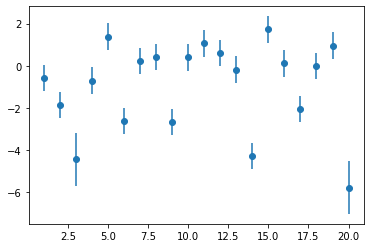

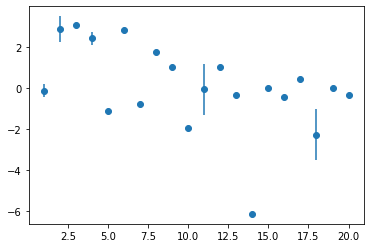

In [49]:
print("THE BEST ARM FOR EXPERIMENT TOTAL IS:",
      arms[best_arm_index], "INDEX", best_arm_index)
print("THE BEST ARM FOR EXPERIMENT ONLY FIRST IS:",
      arms[best_arm_index2], "INDEX", best_arm_index2, "expected")

array = [i+1 for i in range(0, 20)]


plt.figure(1)
plt.errorbar(array, expected_values, yerr=(1/ts_learner.tau0), fmt='o')
plt.figure(0)
plt.errorbar(array, expected_values2, yerr=(1/ts_learner2.tau0), fmt='o')

plt.show()


Here are reward and regret for the case without ad qualities, with only ads in first position
14


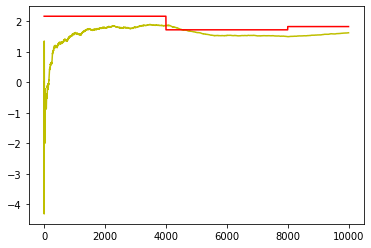

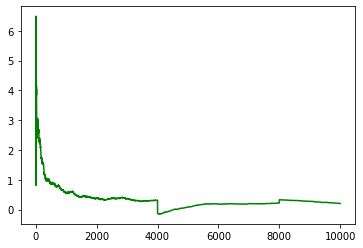

In [ ]:
print("Here are reward and regret for the case without ad qualities, with only ads in first position")
best_values = []
j = 0
k = 0
for i in range(10000):
    k += 1
    best_values.append(clair_ex[j])
    if k == sw_size:
        k = 0
        j += 1

regret_no_qualities = [
    best_values[x] - thing_to_plot[x] for x in range(len(thing_to_plot))]
plt.figure(0)
plt.plot(thing_to_plot, 'y')
plt.plot(best_values, 'r')
plt.figure(1)


plt.plot(regret_no_qualities, 'g')


Here are reward and regret for the case without ad qualities, with only ads in first position


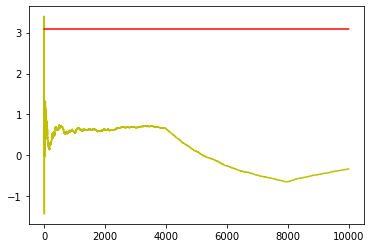

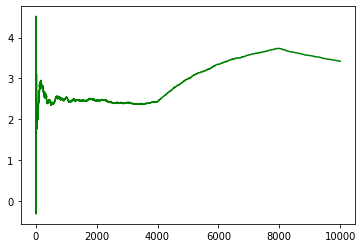

In [55]:
print("Here are reward and regret for the case without ad qualities, with only ads in first position")
best_values2 = []
j = 0
k = 0
for i in range(10000):
    k += 1
    best_values2.append(clair_ex2[j])
    if k == sw_size:
        k = 0
        j += 1

regret_no_qualities2 = [
    best_values2[x] - thing_to_plot2[x] for x in range(len(thing_to_plot2))]
plt.figure(0)
plt.plot(thing_to_plot2, 'y')
plt.plot(best_values2, 'r')
plt.figure(1)


plt.plot(regret_no_qualities2, 'g')
